# House Prices: Advanced Regression Techniques

> Date:2019-09-13,Author:Ho Loong

# 1. 定义问题

[Kaggle:House Prices](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

* Supervise/Unsupervise:Supervise
* Classification/Regression:Regression
* Eval:RMSE
* Train Data:'./input/train.csv', len=1460
* Test Data:'./input/test.csv', len=1460

# 2. 数据来源

Kaggle provide data.

# 3. 加载库

## 3.1 通用库

In [121]:
import sys,os,time,datetime
from collections import Counter

import numpy as np
import pandas as pd
import seaborn as sns

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

### 3.2 ML库

In [168]:
#Common Model Algorithms
from sklearn import ensemble
from xgboost import XGBRegressor

#Common Model Helpers
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, StandardScaler, Binarizer, KBinsDiscretizer
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.decomposition import PCA
from sklearn.model_selection import learning_curve
from sklearn.feature_selection import VarianceThreshold

#Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

#Configure Visualization Defaults
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8

le = LabelEncoder()

# 4. 数据基本信息

In [3]:
def concat_df(train_data, test_data):
    # Returns a concatenated df of training and test set on axis 0
    return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)

def divide_df(all_data):
    # Returns divided dfs of training and test set
    return all_data.loc[:1459], all_data.loc[1460:].drop(['SalePrice'], axis=1)

## 4.1 基本信息

In [4]:
train_data = pd.read_csv('./input/train.csv')
test_data = pd.read_csv('./input/test.csv')

all_data = concat_df(train_data, test_data)

train_data.name = 'TrainSet'
test_data.name = 'TestSet'
all_data.name = 'AllSet'

print train_data.info()
print '-'*100
print test_data.info()
print '-'*100
print train_data.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [5]:
all_data.sample(3)

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
1159,943,933,0,NaN,4,1Fam,TA,No,442.0,0.0,...,WD,0,Pave,8,901.0,AllPub,0,1974,1974,2008
1686,744,630,0,NaN,3,1Fam,TA,Mn,0.0,0.0,...,WD,0,Pave,6,384.0,AllPub,100,2004,2005,2009
459,979,224,0,NaN,3,1Fam,TA,No,185.0,0.0,...,WD,0,Pave,5,709.0,AllPub,0,1950,1950,2009


## 4.2 字段说明

特征说明：

特征名 | 描述 | 类型 | 模式 | 取值 | 缺失情况 | 思考
--|--|--|--|--|--|--
Id|唯一标识符|整型|无序离散|1~2919，不重复|无缺失|测试集中的Id在结果文件中要使用，其他没有用处|
--|--|--|--|--|--|--
MSSubClass|房屋类型|整型|无序离散|60,20,70....|无缺失|房屋类型无疑是对结果影响巨大的因素，尝试挖掘对应类型英文前缀有组的关系可以聚合分析，另外对应的数字的关系尚不可知，可以查一下或者可视化分析|
MSZoning|房屋所处区域分类|字符串|无序离散|A,C,FV....|无缺失|对结果影响很大，需要挖掘，可能需要聚合，结合MSSubClass|
LotArea|面积|整型|连续|N平方英尺|无缺失|跟售价应该是线性关系，可视化找分割点、峰值，qcut、LabelEncode|
LotShape|房屋形状|字符串|半有序离散|Reg,R1,R2,R3|无缺失|按理说应该是左偏分布，毕竟户型方正很重要|
LotFrontage|距离街道直线距离|浮点型|连续|N英尺|缺失200+/1400+|对结果影响较大，可以可视化看分割点、峰值，以及qcut处理|
Street|临近道路类型|字符串|无序枚举|Gravel,Paved|无缺失|因为只有两个取值，因此可以直接LabelEncode、OneHot，考虑跟LotFrontage组合|
Alley|临近胡同类型|字符串|无序枚举|Gravel,Paved,nan|缺失1300+/1400+|该字段缺失是因为没有临近胡同，因此作为一个单独类别填充，可以考虑根据是否有胡同聚合看看信息量|
LandContour|地面平整程度|字符串|半有序离散|Lvl,Bnk,HLS,Low|无缺失|理应左偏|
LandSlope|地面坡度|字符串|半有序离散|Gtl,Mod,Sev|无缺失|理应左偏|
Utilities|可用公共设施|字符串|半有序离散|AllPub,NoSewr,NoSeWa,ELO|无缺失|理应左偏|
LotConfig|配置|字符串|无序离散|Inside内部,Cornel街角,CulDSac死胡同,FR2两面临街,FR3三面临街|无缺失|可视化看差异|
Neighborhood|所处社区|字符串|无序离散|社区名|无缺失|可视化看差异，适当聚合，可以考虑结合MSZoning做社区区域细分分析|
Condition1|房屋优势条件1|字符串|无序离散|接近主干道、公园....|无缺失|一般离散分析|
Condition2|房屋优势条件2|字符串|无序离散|接近主干道、公园....|无缺失|一般离散分析，与1一致，这两个可以组合可视化|
BldgType|房屋类型|字符串|无序离散|独户、联排....|无缺失|考虑跟MSSubClass结合|
HouseStype|装修风格|字符串|无序离散|几楼几底|无缺失|一般离散分析|
OverallQual|材料装修评级|整型|有序离散|10~1|无缺失|离散分析，看看是否需要聚合接近的值|
OverallCond|整体状况评级|整型|有序离散|10~1|无缺失|离散分析，看看是否需要聚合接近的值|
YearBuilt|修建年份|整型|连续|年份|无缺失|构建房龄字段，连续分析，观察分割点、峰值，看是否需要qcut处理|
YearRemodAdd|重装年份|整型|连续|年份|无缺失|构建重装字段，连续分析，观察分割点、峰值，看是否需要qcut处理|
RoofStype|屋顶类型|字符串|无序离散|Flat,Gable,Gambrel,Hip,Mansard,Shed|无缺失|一般离散分析|
RoofMatl|屋顶材料|字符串|无序离散|8中材料|无缺失|结合屋顶风格分析、聚合|
Exterior1st|房屋外层材料|字符串|无序离散|N中材料|无缺失|一般离散分析|
Exterior2nd|同上，如果有两种材料|字符串|无序离散|N中材料|无缺失|结合1一起分析|
MasVnrType|地砖材料|字符串|无序离散|4中材料+nan|缺失8/1400+|一般离散分析|
MasVnrArea|地砖面积|浮点型|连续|面积|缺失8/1400+|缺失可以用0填充表示没有，可视化qcut后可以结合类型分析|
ExterQual|外部材料质量|字符串|有序离散|Ex,Gd,TA,Fa,Po|无缺失|结合材料类型分析|
ExterCond|外部材料现状|字符串|有序离散|Ex,Gd,TA,Fa,Po|无缺失|结合外部材料相关分析聚合|
Foundation|基本材料类型|字符串|无序离散|砖,瓦,石头....|无缺失|一般离散分析|
--|--|--|--|--|--|--
BsmtQual|地下室高度评价|字符串|有序离散|Ex,Gd,TA,Fa,Po,nan|缺失37/1400+|缺失表示无地下室，作为单独类别分析|
BsmtCond|地下室整体情况|字符串|有序离散|Ex,Gd,TA,Fa,Po,nan|缺失37/1400+|缺失表示无地下室，地下室相关特征组合一起分析|
BsmtExposure|地下室曝光情况|字符串|有序离散|Gd,Av,Mn,No,nan|缺失38/1400+|缺失表示无地下室|
BsmtFinType1|地下室1完工面积等级|字符串|有序离散|GLQ,ALQ,BLQ,Rec,LwQ,Unf,nan|缺失37/1400+|缺失表示无地下室|
BsmtFinSF1|1完工面积|整型|连续|面积|无缺失|一般连续分析|
BsmtFinType2|地下室2完工面积等级|字符串|有序离散|GLQ,ALQ,BLQ,Rec,LwQ,Unf,nan|缺失38/1400+|缺失表示无地下室|
BsmtFinSF2|2完工面积|整型|连续|面积|无缺失|一般连续分析|
BsmtUnfSF|地下室未完面积|整型|连续|面积|无缺失|一般连续分析|
TotalBsmtSF|地下室总面积|整型|连续|面积|无缺失|一般连续分析|
--|--|--|--|--|--|--
Heating|暖气方式|字符串|无序离散|Floor,GasA,GasW,Grav,OthW,Wall|无缺失|一般离散分析|
HeatingQC|暖气评价|字符串|有序离散|Ex,Gd,TA,Fa,Po|无缺失|结合Heating分析|
CentralAir|空调|字符串|无序离散|Y,N|无缺失|有无，直接映射到0/1后分析，不需要OneHot|
Electrical|电气系统|字符串|半有序离散|SBrKr,FuseA,FuseF,FuseP,Mix|缺失1/1400+|根据暖气空调同一个社区类型的房屋来填充，应该是偏斜分布图|
1stFlrSF|一楼面积|整型|连续|面积|无缺失|与房屋类型、面积等结合分析，一般连续分析|
2ndFlrSF|二楼面积|整型|连续|面积|无缺失|与房屋类型、面积等结合分析，一般连续分析|
LowQualFinSF|低质量部分面积|整型|连续|面积|无缺失|与房屋类型、面积等结合分析，一般连续分析|
GrLivArea|地上生活区面积|整型|连续|面积|无缺失|与房屋类型、面积等结合分析，一般连续分析|
BsmtFullBath|地下室全浴室个数|整型|连续|个数|无缺失|与房屋类型、面积等结合分析，一般连续分析|
BsmtHalfBath|地下室半浴室个数|整型|连续|个数|无缺失|与房屋类型、面积等结合分析，一般连续分析|
FullBath|全浴室个数|整型|连续|个数|无缺失|与房屋类型、面积等结合分析，一般连续分析|
HalfBath|半浴室个数|整型|连续|个数|无缺失|与房屋类型、面积等结合分析，一般连续分析|
BedroomAbvGr|地上卧室个数|整型|连续|个数|无缺失|与房屋类型、面积等结合分析，一般连续分析|
KitchenAbvGr|地上厨房个数|整型|连续|个数|无缺失|与房屋类型、面积等结合分析，一般连续分析|
KitchenQual|厨房质量|字符串|有序离散|Ex,Gd,TA,Fa,Po|无缺失|与厨房结合分析，一般离散分析|
TotRmsAbvGrd|地上房间个数（不包括卧室）|整型|连续|个数|无缺失|与房屋类型、面积等结合分析，一般连续分析，构建房间总数、几室几厅几卫|
Functional|家庭设施情况|字符串|有序离散|Typ,Min1,Min2,Mod,Maj1,Maj2,Sev,Sal|无缺失|一般离散分析|
Fireplaces|壁炉数量|整型|连续|个数|无缺失|一般连续分析|
FireplaceQu|壁炉质量|字符串|有序离散|Ex,Gd,TA,Fa,Po,nan|缺失700+/1400+|缺失表示没有壁炉，单独类别即可，结合壁炉数量分析|
--|--|--|--|--|--|--
GarageType|车库位置|字符串|无序离散|2Type,Attchd,Basment,BuiltIn,CarPort,Detchd,nan|缺失80+/1400+|缺失表示没有车库，车库相关的组合一起分析|
GarageYrBlt|车库建造年份|浮点型|连续|年份|缺失80+/1400+|缺失表示没有，构建车库年龄|
GarageFinish|车库内部情况|字符串|有序离散|Fin,RFn,Unf,nan|缺失80+/1400+|缺失表示没有|
GarageCars|车库能放几辆车|整型|连续|个数|无缺失|没有车库为0|
GarageArea|车库面积|整型|连续|面积|无缺失|没有车库为0|
GarageQual|车库质量|字符串|有序离散|Ex,Gd,TA,Fa,Po,nan|缺失80+/1400+|缺失表示没有|
GarageCond|车库状况|字符串|有序离散|Ex,Gd,TA,Fa,Po,nan|缺失80+/1400+|缺失表示没有|
--|--|--|--|--|--|--
PavedDrive|车道铺面情况|字符串|有序离散|Y,P,R|无缺失|一般离散分析|
WoodDeckSF|木地板面积|整型|连续|面积|无缺失|一般连续分析|
OpenPorchSF|开放式门廊面积|整型|连续|面积|无缺失|一般连续分析|
EnclosedPorch|围挡走廊面积|整型|连续|面积|无缺失|一般连续分析|
3SsnPorch|三季门廊面积|整型|连续|面积|无缺失|一般连续分析|
ScreenPorch|屏风廊面积|整型|连续|面积|无缺失|一般连续分析|
PoolArea|泳池面积|整型|连续|面积|无缺失|一般连续分析|
PoolQC|泳池质量|字符串|有序离散|Ex,Gd,TA,Fa,nan|缺失1400+/1400+|结合泳池面积分析，训练数据只有7个房屋有泳池|
Fence|围栏质量|字符串|半有序离散|GdPrv,MnPrv,GdWo,MnWw,nan|缺失1200+/1400+|一般离散分析|
MiscFeature|杂项|字符串|无序离散|杂项|缺失1400+/1400+|杂项，结合下面价值分析|
MiscVal|杂项价值|整型|连续|美元|无缺失|结合杂项分析|
--|--|--|--|--|--|--
MoSold|售出月份|整型|连续|月份|无缺失|结合年份|
YrSold|售出年份|整型|连续|年份|无缺失|结合月份，结合房屋、重装、车库等修建时间，生成时长特征，另外可以分析同期销售情况|
SaleType|付款方式|字符串|半有序离散|类别字符串|无缺失|总价应该是跟付款方式有关的，例如全款总价会低一些，贷款会高一些，重要指标|
SaleCondition|销售条件|字符串|半有序离散|条件字符串|无缺失|异常情况对应的总价是否是异常的需要可视化时格外关注|
--|--|--|--|--|--|--
SalePrice|售价|整型|连续|美元|无缺失|只存在于训练数据，属于测试数据的目标预测值|

PS：特征间组合还要看相关性后再决定；

PPS：1平方英尺大约等于0.09平米；

## 4.3 其他特征与目标特征关系TODO

## 4.4 数据分布TODO

## 4.5 小结TODO

# 5. 数据预处理

In [6]:
# 连续特征
ContinuousFeatures = ['LotArea','LotFrontage','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal']

# 离散特征
CategoricalFeatures = ['MSSubClass','MSZoning','LotShape','Street','Alley','LandContour','LandSlope','Utilities','LotConfig','Neighborhood','Condition1','Condition2','BldgType','HouseStyle','OverallQual','OverallCond','YearBuilt','YearRemodAdd','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','ExterQual','ExterCond','Foundation','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','Heating','CentralAir','Electrical','KitchenQual','Functional','FireplaceQu','GarageType','GarageYrBlt','GarageFinish','GarageQual','GarageCond','PavedDrive','PoolQC','Fence','MiscFeature','MoSold','YrSold','SaleType','SaleCondition']

# 目标特征
TargetFeature = 'SalePrice'

# 需要手动指定映射关系的离散特征
CategoricalOrderFeatures = ['LotShape','LandContour','LandSlope','Utilities','OverallQual','OverallCond','ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','HeatingQC','Electrical','KitchenQual','Functional','FireplaceQu','GarageFinish','GarageQual','GarageCond','PavedDrive','PoolQC','Fence','SaleType','SaleCondition']

# 日期时间相关
TimeSerieFeatures = ['YearBuilt','YearRemodAdd','GarageYrBlt','YrSold','MoSold']

# 房屋性质、位置、社区、社区类型、街道相关
# 面积、房间个数、地下室、车库、厨房相关
# 房屋内饰、装修、地板、材料、电力、公共设施、空调壁炉等相关
# 售卖相关

In [7]:
def heatmap(df, target_cols, ignore_cols):
    cols = list(df.columns)
#     for col in target_cols:
#         del cols[cols.index(col)]
#     for col in ignore_cols:
#         del cols[cols.index(col)]
    for i in range(0,len(cols),10):
        tmp = df[cols[i:i+10]]
    
        _ , ax = plt.subplots(figsize =(15, 15))
        colormap = sns.diverging_palette(220, 10, as_cmap = True)

        _ = sns.heatmap(
            tmp.corr(), 
            cmap = colormap,
            square=True, 
            cbar_kws={'shrink':.9 }, 
            ax=ax,
            annot=True, 
            linewidths=0.1,vmax=1.0, linecolor='white',
            annot_kws={'fontsize':12 }
        )
    
    plt.title('House Prices Correlation of Features', y=1.05, size=15)

In [8]:
def corr_df(df_all, target, min_=0.1):
    df_all_corr = df_all.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
    df_all_corr.rename(columns={"level_0": "Target", "level_1": "Source", 0: 'Correlation Coefficient'}, inplace=True)
    return df_all_corr[df_all_corr['Target'] == target][df_all_corr['Source'] != target][df_all_corr['Correlation Coefficient'].abs()>=min_]

In [9]:
def entropy(D):
    count_array=np.array(Counter(D).values())
    P=count_array/float(count_array.sum())
    H=np.dot(-P,np.log2(P))
    return H

def condition_entropy(D,A):
    A=np.array(A)
    D=np.array(D)
    H_da=0
    for i in np.unique(A):
        index_i=np.ravel(np.argwhere(A==i))
        Di=D[index_i]
        H_Di=entropy(Di)
        pi=float(Di.size)/D.size
        H_da=H_da+pi*H_Di
    return H_da

def gain(y, x):
    return entropy(y) - condition_entropy(y, x)

def gain_ratio(y, x):
    '''
    说明：计算y和x的信息增益比，注意这里是除以x的信息增益，也就是对x的取值的离散度计算一个惩罚值，最明显的就是ID字段
    '''
    return gain(y,x) / entropy(x)

def gain_df(df, target):
    dict_ = {}
    y = df[target]
    if y.dtype=='object':
        y = le.fit_transform(y)
    for col in df.columns:
        if col == target:
            continue
        x = df[col]
        if x.dtype=='object':
            x = le.fit_transform(x)
        dict_[col] = (gain(y,x),gain_ratio(y,x))
    return sorted(dict_.items(),key=lambda v:v[1][1],reverse=True)

In [10]:
def barplot(col_data):
    vc = col_data.value_counts()
    sns.barplot(x=list(vc.index), y=list(vc.values), palette="rocket")

## 5.0 处理缺失值

部分算法不允许有缺失值，且缺失的原因多种多样，通常需要对缺失进行处理，缺失值的填充需要尽可能从业务出发，参考相似性高的其他特征来填充，且填充方式要灵活；

- Imputer；
- FunctionTransformer；

这里缺失值的填充是较为灵活复杂的，无法直接使用Imputer来填充，构建一个类，提供fit、transform、fit_transform方法来填充各个列，方便后续加入到Pipe中；

In [11]:
print 'All data columns with null values:\n'
missing_data = all_data.isnull().sum()[all_data.isnull().sum()>0].sort_values()
missing_cols = list(missing_data.index)
print missing_data
print missing_cols

All data columns with null values:

GarageArea         1
SaleType           1
KitchenQual        1
BsmtFinSF1         1
BsmtFinSF2         1
GarageCars         1
TotalBsmtSF        1
Exterior2nd        1
Exterior1st        1
BsmtUnfSF          1
Electrical         1
Functional         2
Utilities          2
BsmtHalfBath       2
BsmtFullBath       2
MSZoning           4
MasVnrArea        23
MasVnrType        24
BsmtFinType1      79
BsmtFinType2      80
BsmtQual          81
BsmtCond          82
BsmtExposure      82
GarageType       157
GarageYrBlt      159
GarageFinish     159
GarageCond       159
GarageQual       159
LotFrontage      486
FireplaceQu     1420
SalePrice       1459
Fence           2348
Alley           2721
MiscFeature     2814
PoolQC          2909
dtype: int64
['GarageArea', 'SaleType', 'KitchenQual', 'BsmtFinSF1', 'BsmtFinSF2', 'GarageCars', 'TotalBsmtSF', 'Exterior2nd', 'Exterior1st', 'BsmtUnfSF', 'Electrical', 'Functional', 'Utilities', 'BsmtHalfBath', 'BsmtFullBath', '

**缺失数据分析**

缺失通常有两个原因，一个是技术性缺失，一个是合理性缺失，通常技术性缺失需要通过某些方式来填充或者无法填充可能会丢弃，具体看该字段缺失情况以及是否与目标字段相关性强，而合理性缺失通常用一个特殊值来表示缺失，即缺失也是一种取值，或者压根不补充都是可以的；

处理过程由缺失数量少的一组一组的开始依次进行；

### 5.1.1 Garage部分

- GarageArea：1；
- GarageCars：1；
- GarageType：157；
- GarageYrBlt：159；
- GarageFinish：159；
- GarageCond：159；
- GarageQual：159；

In [12]:
garage_list = [col for col in all_data.columns.tolist() if col.startswith('Garage')]
garage_list

['GarageArea',
 'GarageCars',
 'GarageCond',
 'GarageFinish',
 'GarageQual',
 'GarageType',
 'GarageYrBlt']

#### GarageArea、GarageCars

这两个都是缺失了一个值，可以看到是同一条数据缺失了Area和Cars，且Garage相关的只有一个Type有值，值为Detchd，表示Detached from home，即与家分离的车库，可以看到其他Detchd的数据其他字段是有值的，因此这个应该是技术性缺失，需要填充；

In [13]:
garage_data = all_data[garage_list][pd.isnull(all_data.GarageArea)]
garage_data

,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt
2576,NaN,NaN,NaN,NaN,NaN,Detchd,NaN


In [14]:
all_data[garage_list][all_data.GarageType == 'Detchd'].sample(3)

,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt
235,264.0,1.0,TA,Unf,TA,Detchd,1971.0
2200,400.0,2.0,TA,Unf,TA,Detchd,1994.0
1900,440.0,2.0,TA,Unf,TA,Detchd,1961.0


计算相关性，寻找可能用于填充GarageArea和GarageCars的特征，因为Area和Cars相关性很高，因此计算其中一个就可以了，从结果上看相关性最高的5个字段，只有三个有值，分别是TotalBsmtSF地下室总面积、1stFlrSF一楼面积、OverallQual材料装修评级，其中OverallQual最高，那么就使用该字段填充area，再用area填充cars；

In [15]:
corr_df(all_data, 'GarageArea', 0.2)[:6]

,Target,Source,Correlation Coefficient
39,GarageArea,GarageCars,0.889700
63,GarageArea,SalePrice,0.623431
87,GarageArea,OverallQual,0.565122
93,GarageArea,GarageYrBlt,0.555836
117,GarageArea,1stFlrSF,0.492011
125,GarageArea,TotalBsmtSF,0.486067


In [16]:
all_data[['OverallQual']+garage_list][pd.isnull(all_data.GarageArea)]

,OverallQual,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt
2576,5,NaN,NaN,NaN,NaN,NaN,Detchd,NaN


In [17]:
area_by_overallqual = all_data.groupby(['OverallQual']).median()['GarageArea']

for oq in all_data.OverallQual.unique():
    print('Median area of OQ {}: {}'.format(oq, area_by_overallqual[oq]))
print('Median area of all: {}'.format(all_data['GarageArea'].median()))

Median area of OQ 7: 514.0
Median area of OQ 6: 442.0
Median area of OQ 8: 670.0
Median area of OQ 5: 352.0
Median area of OQ 9: 768.0
Median area of OQ 4: 296.5
Median area of OQ 10: 846.0
Median area of OQ 3: 245.0
Median area of OQ 1: 135.0
Median area of OQ 2: 256.0
Median area of all: 480.0


In [18]:
all_data['GarageArea'] = all_data.groupby(['OverallQual'])['GarageArea'].apply(lambda x: x.fillna(x.median()))
all_data[['OverallQual']+['GarageType','GarageArea']][pd.isnull(all_data.GarageCars)]

,OverallQual,GarageType,GarageArea
2576,5,Detchd,352.0


In [19]:
cars_by_overallqual = all_data.groupby(['OverallQual']).median()['GarageCars']

for oq in all_data.OverallQual.unique():
    print('Median cars of OQ {}: {}'.format(oq, cars_by_overallqual[oq]))
print('Median cars of all: {}'.format(all_data['GarageCars'].median()))

Median cars of OQ 7: 2.0
Median cars of OQ 6: 2.0
Median cars of OQ 8: 2.0
Median cars of OQ 5: 1.0
Median cars of OQ 9: 3.0
Median cars of OQ 4: 1.0
Median cars of OQ 10: 3.0
Median cars of OQ 3: 1.0
Median cars of OQ 1: 0.5
Median cars of OQ 2: 1.0
Median cars of all: 2.0


In [20]:
all_data['GarageCars'] = all_data.groupby(['OverallQual'])['GarageCars'].apply(lambda x: x.fillna(x.median()))
all_data[['OverallQual']+['GarageType','GarageCars']].iloc[2576]

OverallQual         5
GarageType     Detchd
GarageCars          1
Name: 2576, dtype: object

#### GarageType、GarageYrBlt、GarageFinish、GarageCond、GarageQual

Type缺失157个，其余缺失159个，也就是有两个是有Type而没有其他四个字段的，这两个要关注一下，其余157个考虑直接用None替代；

In [21]:
all_data[garage_list][pd.isnull(all_data.GarageFinish)][all_data.GarageArea>0]

,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt
2126,360.0,1.0,NaN,NaN,NaN,Detchd,NaN
2576,352.0,1.0,NaN,NaN,NaN,Detchd,NaN


可以看到，这两个特别的点又是Detchd的，也就是与家分离的车库，那么对这两个的填充，就基于Detchd；

In [22]:
print all_data[all_data.GarageType=='Detchd'].groupby('GarageCond')['Id'].count().sort_values()[-3:]
print all_data[all_data.GarageType=='Detchd'].groupby('GarageFinish')['Id'].count().sort_values()[-3:]
print all_data[all_data.GarageType=='Detchd'].groupby('GarageQual')['Id'].count().sort_values()[-3:]
#print all_data[all_data.OverallQual==5][all_data.GarageType=='Detchd'][all_data.GarageFinish=='Unf'].groupby('GarageYrBlt')['Id'].count().sort_values()

GarageCond
Po     12
Fa     67
TA    692
Name: Id, dtype: int64
GarageFinish
Fin     24
RFn     34
Unf    719
Name: Id, dtype: int64
GarageQual
Po      5
Fa     97
TA    667
Name: Id, dtype: int64


In [23]:
all_data[all_data.GarageArea>0][pd.isnull(all_data.GarageCond)]['GarageCond'] = 'TA'
all_data[all_data.GarageArea>0][pd.isnull(all_data.GarageFinish)]['GarageFinish'] = 'Unf'
all_data[all_data.GarageArea>0][pd.isnull(all_data.GarageQual)]['GarageQual'] = 'TA'

对于GarageYrBlt，因此得到的数据过于零散，通过相关性来填充，能够看到，跟房屋建造年限有关，因此使用该字段进行填充；

In [24]:
corr_df(all_data, 'GarageYrBlt', min_=0.2)[:5]

,Target,Source,Correlation Coefficient
40,GarageYrBlt,YearBuilt,0.834812
55,GarageYrBlt,YearRemodAdd,0.652365
76,GarageYrBlt,GarageCars,0.587712
82,GarageYrBlt,OverallQual,0.571803
92,GarageYrBlt,GarageArea,0.555836


In [25]:
yrblt_by_yearbuilt = all_data.groupby(['YearBuilt']).median()['GarageYrBlt']

for oq in all_data.YearBuilt.unique():
    print('Median cars of OQ {}: {}'.format(oq, yrblt_by_yearbuilt[oq]))
print('Median cars of all: {}'.format(all_data['GarageYrBlt'].median()))

Median cars of OQ 2003: 2003.0
Median cars of OQ 1976: 1976.0
Median cars of OQ 2001: 2001.0
Median cars of OQ 1915: 1950.0
Median cars of OQ 2000: 2000.0
Median cars of OQ 1993: 1993.0
Median cars of OQ 2004: 2004.0
Median cars of OQ 1973: 1973.0
Median cars of OQ 1931: 1931.0
Median cars of OQ 1939: 1939.0
Median cars of OQ 1965: 1965.0
Median cars of OQ 2005: 2005.0
Median cars of OQ 1962: 1962.0
Median cars of OQ 2006: 2006.0
Median cars of OQ 1960: 1960.0
Median cars of OQ 1929: 1970.5
Median cars of OQ 1970: 1970.0
Median cars of OQ 1967: 1967.0
Median cars of OQ 1958: 1958.0
Median cars of OQ 1930: 1930.0
Median cars of OQ 2002: 2002.0
Median cars of OQ 1968: 1968.0
Median cars of OQ 2007: 2007.0
Median cars of OQ 1951: 1951.0
Median cars of OQ 1957: 1957.0
Median cars of OQ 1927: 1927.0
Median cars of OQ 1920: 1925.0
Median cars of OQ 1966: 1966.0
Median cars of OQ 1959: 1959.0
Median cars of OQ 1994: 1994.0
Median cars of OQ 1954: 1954.0
Median cars of OQ 1953: 1953.0
Median c

In [26]:
all_data['GarageYrBlt'] = all_data.groupby(['YearBuilt'])['GarageYrBlt'].apply(lambda x: x.fillna(x.median()))
all_data[['YearBuilt','GarageYrBlt']].iloc[[2126,2576]]

,YearBuilt,GarageYrBlt
2126,1910,1950.0
2576,1923,1923.0


下面检查另外157个缺失是否都是因为没有车库导致的，如果是那么用'None'填充，通过打印可以看到157个都满足面积为0，因此这157个case都是没有车库，那么GarageType填充为'None'、GarageYrBlt填充为0（填充为0表示没有车库的车库建造年限字段，后续注意，另外在qcut时，0会跟最老的年限合到一起，可以理解为很久的车库跟没有一样，这样处理应该合理一些）、GarageFinish填充为'None'、GarageCond填充为'None'、GarageQua填充为'None'；

In [27]:
print 'Size of finish is nan, area=0, cars=0',len(all_data[garage_list][pd.isnull(all_data.GarageFinish)][all_data.GarageArea<=0.0][all_data.GarageCars==0.0])

Size of finish is nan, area=0, cars=0 157


In [28]:
all_data.GarageType.fillna('None', inplace=True)
all_data.GarageFinish.fillna('None', inplace=True)
all_data.GarageCond.fillna('None', inplace=True)
all_data.GarageQual.fillna('None', inplace=True)
all_data.GarageYrBlt.fillna(0, inplace=True)

#### 检查下Garage下是否还有nan

可以看到已经全部被填充了；

In [29]:
all_data[garage_list].isnull().sum()[all_data.isnull().sum()>0].sort_values()

Series([], dtype: int64)

### 5.1.2 Bsmt部分

- TotalBsmtSF：1，地下室面积
- BsmtFinSF1：1，1完工面积
- BsmtFinSF2：1，2完工面积
- BsmtUnfSF：1，地下室未完面积
- BsmtHalfBath：2，地下室半浴室个数
- BsmtFullBath：2，地下室全浴室个数
- BsmtFinType1：79，地下室1完工面积等级
- BsmtFinType2：80，地下室2完工面积等级
- BsmtQual：81，地下室高度评价
- BsmtCond：82，地下室整体情况
- BsmtExposure：82，地下室曝光情况

In [30]:
bsmt_list = [col for col in all_data.columns.tolist() if col.find('Bsmt')!=-1]
bsmt_list

['BsmtCond',
 'BsmtExposure',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtFinType1',
 'BsmtFinType2',
 'BsmtFullBath',
 'BsmtHalfBath',
 'BsmtQual',
 'BsmtUnfSF',
 'TotalBsmtSF']

#### BsmtFinType1、BsmtFinType2、BsmtQual、BsmtCond、BsmtExposure

从这五个开始因为在文档中说明，这5个字段为null表示没有车库，而这五个的缺失不是一致的，最少的是Type1为79，最多为Cond和Exposure为82，因此先从Type1开始，看到这79个地下室相关均为NaN和0，因此直接填充即可，字符枚举用'None'，数值用0；

In [31]:
all_data[bsmt_list][pd.isnull(all_data.BsmtFinType1)]

,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,TotalBsmtSF
17,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0
39,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0
90,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0
102,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0
156,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0
182,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0
259,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0
342,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0
362,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0
371,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0


In [32]:
all_data['TotalBsmtSF'][pd.isnull(all_data.BsmtFinType1)] = 0.0
all_data['BsmtFinSF1'][pd.isnull(all_data.BsmtFinType1)] = 0.0
all_data['BsmtFinSF2'][pd.isnull(all_data.BsmtFinType1)] = 0.0
all_data['BsmtUnfSF'][pd.isnull(all_data.BsmtFinType1)] = 0.0
all_data['BsmtFullBath'][pd.isnull(all_data.BsmtFinType1)] = 0.0
all_data['BsmtHalfBath'][pd.isnull(all_data.BsmtFinType1)] = 0.0

all_data['BsmtCond'][pd.isnull(all_data.BsmtFinType1)] = 'None'
all_data['BsmtExposure'][pd.isnull(all_data.BsmtFinType1)] = 'None'
all_data['BsmtFinType2'][pd.isnull(all_data.BsmtFinType1)] = 'None'
all_data['BsmtQual'][pd.isnull(all_data.BsmtFinType1)] = 'None'
# 注意此处：对Type1的操作要放到最后，因为条件中依赖了Type1
all_data['BsmtFinType1'][pd.isnull(all_data.BsmtFinType1)] = 'None'

In [33]:
len(all_data[bsmt_list][pd.isnull(all_data.BsmtFinType1)])

0

In [34]:
all_data[bsmt_list].isnull().sum()

BsmtCond        3
BsmtExposure    3
BsmtFinSF1      0
BsmtFinSF2      0
BsmtFinType1    0
BsmtFinType2    1
BsmtFullBath    0
BsmtHalfBath    0
BsmtQual        2
BsmtUnfSF       0
TotalBsmtSF     0
dtype: int64

#### BsmtCond 3、BsmtExposure 3、BsmtQual 2、BsmtFinType2 1

看到剩下的全是离散型特征有少许缺失，需要依次处理：
- BsmtFinType2：只缺失一条，且看到BsmtUnfSF大于0，且一个Type为GLQ的情况下Type2都是Ulf，10个sample也可以证明这一点，而此处Type1为GLQ，因此Type2为Unf；
- BsmtExposure：缺失的三条，都属于地下室还没开始建的情况，用'No'填充即可，因为并不是没有地下室；
- BsmtQual：缺失两条，根据年份来填充；
- BsmtCOnd：缺失三条，根据年份来填充；

TODO：这里Qual、Cond没有找到很好的填充方法，先使用众数填充；

In [35]:
all_data[bsmt_list][pd.isnull(all_data.BsmtFinType2)]

,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,TotalBsmtSF
332,TA,No,1124.0,479.0,GLQ,NaN,1.0,0.0,Gd,1603.0,3206.0


In [36]:
all_data[all_data.BsmtUnfSF>0][all_data.BsmtFinType1=='GLQ'].sample(10)[['BsmtUnfSF', 'BsmtFinType1', 'BsmtFinType2']]

,BsmtUnfSF,BsmtFinType1,BsmtFinType2
588,113.0,GLQ,Unf
1741,249.0,GLQ,Unf
1870,1474.0,GLQ,Unf
1887,100.0,GLQ,Unf
507,1191.0,GLQ,Unf
618,1774.0,GLQ,Unf
2565,741.0,GLQ,Unf
1632,195.0,GLQ,Unf
1109,797.0,GLQ,Unf
1697,282.0,GLQ,Unf


In [37]:
all_data['BsmtFinType2'][pd.isnull(all_data.BsmtFinType2)] = 'Unf'

In [38]:
all_data[bsmt_list][pd.isnull(all_data.BsmtExposure)]

,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,TotalBsmtSF
948,TA,NaN,0.0,0.0,Unf,Unf,0.0,0.0,Gd,936.0,936.0
1487,TA,NaN,0.0,0.0,Unf,Unf,0.0,0.0,Gd,1595.0,1595.0
2348,TA,NaN,0.0,0.0,Unf,Unf,0.0,0.0,Gd,725.0,725.0


In [39]:
all_data['BsmtExposure'][pd.isnull(all_data.BsmtExposure)] = 'No'

In [40]:
all_data[['YearBuilt','YearRemodAdd','GarageYrBlt','BsmtQual']][pd.isnull(all_data.BsmtQual)]

,YearBuilt,YearRemodAdd,GarageYrBlt,BsmtQual
2217,1895,1950,1895.0,NaN
2218,1910,2000,1910.0,NaN


In [41]:
all_data[all_data.YearBuilt == 1895]['BsmtQual'].value_counts()

Gd    1
TA    1
Name: BsmtQual, dtype: int64

In [42]:
all_data[all_data.YearBuilt == 1910]['BsmtQual'].value_counts()

TA      27
Fa       9
Gd       5
None     1
Name: BsmtQual, dtype: int64

In [43]:
all_data['BsmtQual'][pd.isnull(all_data.BsmtQual)] = 'TA'

In [44]:
all_data[['YearBuilt','YearRemodAdd','GarageYrBlt','BsmtCond']][pd.isnull(all_data.BsmtCond)]

,YearBuilt,YearRemodAdd,GarageYrBlt,BsmtCond
2040,1976,2007,1976.0,NaN
2185,1976,1976,1991.0,NaN
2524,1977,1977,1977.0,NaN


In [45]:
all_data[all_data.YearBuilt == 1976]['BsmtCond'].value_counts()

TA      46
Gd       5
None     1
Name: BsmtCond, dtype: int64

In [46]:
all_data[all_data.YearBuilt == 1977]['BsmtCond'].value_counts()

TA      48
Gd       5
None     3
Name: BsmtCond, dtype: int64

In [47]:
all_data['BsmtCond'][pd.isnull(all_data.BsmtCond)] = 'TA'

In [48]:
all_data[bsmt_list].isnull().sum()

BsmtCond        0
BsmtExposure    0
BsmtFinSF1      0
BsmtFinSF2      0
BsmtFinType1    0
BsmtFinType2    0
BsmtFullBath    0
BsmtHalfBath    0
BsmtQual        0
BsmtUnfSF       0
TotalBsmtSF     0
dtype: int64

### 5.1.3 其他

#### PoolQC

该值的nan文档中说明表示没用泳池，我们使用PoolArea来辅助验证一下，因为PoolArea是没有缺失的，看到其中2906个都是0，这写用None来填充即可，但是还有3个Area不是0，这三个要特别处理下；

In [49]:
len(all_data[['PoolArea', 'PoolQC']][pd.isnull(all_data.PoolQC)][all_data.PoolArea==0])

2906

In [50]:
all_data[['PoolArea', 'PoolQC']][pd.isnull(all_data.PoolQC)][all_data.PoolArea>0]

,PoolArea,PoolQC
2420,368,NaN
2503,444,NaN
2599,561,NaN


In [51]:
all_data[['PoolArea','PoolQC']].groupby('PoolQC').median()

,PoolArea
PoolQC,
Ex,370.0
Fa,583.5
Gd,657.0


In [52]:
all_data['PoolQC'].iloc[2420] = 'Ex'
all_data['PoolQC'].iloc[2503] = 'Ex'
all_data['PoolQC'].iloc[2599] = 'Fa'

In [53]:
all_data['PoolQC'][pd.isnull(all_data.PoolQC)] = 'None'

In [54]:
all_data[['PoolArea', 'PoolQC']][pd.isnull(all_data.PoolQC)]

,PoolArea,PoolQC


#### MiscFeature

结合MiscVal填充，MiscVal为0时，表示没有任何价值，为其他值时，则根据价值对应的Feature值填充，可以看到，为0的有2813个，还有一个要关注下，看到这个特殊的点的val高达17000，而最高的Gar2才8000，最接近，预计为Gar2，其余填充'None'；

In [55]:
len(all_data[['MiscFeature', 'MiscVal']][pd.isnull(all_data.MiscFeature)][all_data.MiscVal==0])

2813

In [56]:
all_data[['MiscFeature', 'MiscVal']][pd.isnull(all_data.MiscFeature)][all_data.MiscVal>0]

,MiscFeature,MiscVal
2549,NaN,17000


In [57]:
all_data[['MiscFeature','MiscVal']].groupby('MiscFeature').median()

,MiscVal
MiscFeature,
Gar2,8300
Othr,3250
Shed,500
TenC,2000


In [58]:
all_data['MiscFeature'].iloc[2549] = 'Gar2'

In [59]:
all_data['MiscFeature'][pd.isnull(all_data.MiscFeature)] = 'None'

In [60]:
all_data[['MiscFeature', 'MiscVal']][pd.isnull(all_data.MiscFeature)]

,MiscFeature,MiscVal


#### FireplaceQu

结合Fireplaces填充，places为0，填充为'None'；

In [61]:
len(all_data[['FireplaceQu', 'Fireplaces']][pd.isnull(all_data.FireplaceQu)][all_data.Fireplaces==0])

1420

In [62]:
all_data['FireplaceQu'][pd.isnull(all_data.FireplaceQu)] = 'None'

In [63]:
all_data[['FireplaceQu', 'Fireplaces']][pd.isnull(all_data.FireplaceQu)]

,FireplaceQu,Fireplaces


#### Fence、Alley

这两个没有其他直接关联的字段，而文档中说明了nan表示没有，因此直接填充为'None'；

In [64]:
all_data['Fence'][pd.isnull(all_data.Fence)] = 'None'

In [65]:
all_data['Alley'][pd.isnull(all_data.Alley)] = 'None'

#### Electrical

电力系统缺失1，使用其他跟电力相关字段填充，比如CentralAir、Utilities、暖气等，看到同样暖气、空调、资源情况，对应的都是SBrkr，因此用SBrkr填充即可；

In [66]:
all_data[['Electrical','CentralAir','Utilities','Heating']][pd.isnull(all_data.Electrical)]

,Electrical,CentralAir,Utilities,Heating
1379,NaN,Y,AllPub,GasA


In [67]:
all_data[['Electrical','CentralAir','Utilities','Heating']][all_data.CentralAir=='Y'].sample(5)

,Electrical,CentralAir,Utilities,Heating
967,SBrkr,Y,AllPub,GasA
1051,SBrkr,Y,AllPub,GasA
82,SBrkr,Y,AllPub,GasA
47,SBrkr,Y,AllPub,GasA
2091,FuseA,Y,AllPub,GasA


In [68]:
all_data['Electrical'][pd.isnull(all_data.Electrical)] = 'SBrkr'

#### Utilities
缺失2，可用资源类型，煤气、瓦斯等，跟上面的电力系统填充类似的方式，

In [69]:
all_data[['Electrical','CentralAir','Utilities','Heating']][pd.isnull(all_data.Utilities)]

,Electrical,CentralAir,Utilities,Heating
1915,FuseA,N,NaN,GasA
1945,FuseA,Y,NaN,GasA


In [70]:
all_data[['Electrical','CentralAir','Utilities','Heating']][all_data.Electrical=='FuseA'].sample(5)

,Electrical,CentralAir,Utilities,Heating
1809,FuseA,Y,AllPub,GasA
1223,FuseA,N,AllPub,GasA
976,FuseA,Y,AllPub,GasA
2574,FuseA,Y,AllPub,GasA
1119,FuseA,Y,AllPub,GasA


In [71]:
all_data['Utilities'][pd.isnull(all_data.Utilities)] = 'ALLPub'

#### KitchenQual
缺失1，厨房质量，利用整体状况来填充；

In [72]:
all_data[['KitchenQual','HouseStyle']][pd.isnull(all_data.KitchenQual)]

,KitchenQual,HouseStyle
1555,NaN,1.5Fin


In [73]:
all_data[all_data.HouseStyle=='1.5Fin']['KitchenQual'].value_counts()

TA    229
Gd     62
Fa     18
Ex      4
Name: KitchenQual, dtype: int64

In [74]:
all_data['KitchenQual'][pd.isnull(all_data.KitchenQual)] = 'TA'

#### Exterior

外部材料相关，另个都是缺失1，Exterior1st、Exterior2nd，使用Exter相关来填充，可以看到ExterQual、ExterCond均为TA，而TA对应的材料为VinylSd；

In [75]:
all_data[['Exterior1st','Exterior2nd', 'ExterQual', 'ExterCond']][pd.isnull(all_data.Exterior1st)]

,Exterior1st,Exterior2nd,ExterQual,ExterCond
2151,NaN,NaN,TA,TA


In [76]:
all_data[all_data.ExterCond=='TA']['Exterior1st'].value_counts()

VinylSd    929
HdBoard    400
MetalSd    360
Wd Sdng    340
Plywood    191
CemntBd    118
BrkFace     78
WdShing     48
AsbShng     32
Stucco      31
BrkComm      5
Stone        2
AsphShn      1
ImStucc      1
CBlock       1
Name: Exterior1st, dtype: int64

In [77]:
all_data[all_data.ExterCond=='TA']['Exterior2nd'].value_counts()

VinylSd    915
HdBoard    362
MetalSd    356
Wd Sdng    327
Plywood    231
CmentBd    117
Wd Shng     69
BrkFace     42
Stucco      40
AsbShng     29
Brk Cmn     21
ImStucc     15
Stone        6
AsphShn      3
CBlock       3
Other        1
Name: Exterior2nd, dtype: int64

In [78]:
all_data['Exterior1st'][pd.isnull(all_data.Exterior1st)] = 'VinylSd'

In [79]:
all_data['Exterior2nd'][pd.isnull(all_data.Exterior2nd)] = 'VinylSd'

#### SaleType
缺失1，销售类型，结合SaleCondition填充；

In [80]:
all_data[['SaleType','SaleCondition']][pd.isnull(all_data.SaleType)]

,SaleType,SaleCondition
2489,NaN,Normal


In [81]:
all_data[all_data.SaleCondition=='Normal']['SaleType'].value_counts()

WD       2314
COD        39
ConLD      21
CWD        10
ConLw       7
ConLI       5
Con         4
Oth         1
Name: SaleType, dtype: int64

In [82]:
all_data['SaleType'][pd.isnull(all_data.SaleType)] = 'WD'

#### Functional
缺失2，其他功能，暂时没想到跟哪个字段有直接联系，使用最多的值填充；

In [83]:
all_data.Functional.value_counts()

Typ     2717
Min2      70
Min1      65
Mod       35
Maj1      19
Maj2       9
Sev        2
Name: Functional, dtype: int64

In [84]:
all_data['Functional'][pd.isnull(all_data.Functional)] = 'Typ'

#### MasVnr
MasVnrArea缺失23，砖石面积，MasVnrType缺失24，砖石类型，用信息增益比来分析相关性，对于Area来说，信息增益比最高为Type，但是由于缺失的Area对应Type也是缺失的，因此考虑使用3SsnPorch三季门廊面积来填充，而Type用Area填充；

TODO：考虑使用连续值来填充连续值的更合理的方式；

In [85]:
gain_df(all_data, 'MasVnrArea')[:5]

[('MasVnrType', (1.1766042833771735, 0.8498058023621885)),
 ('3SsnPorch', (0.06245989991848511, 0.3934010643201928)),
 ('Utilities', (0.004950147911600311, 0.39201368810279524)),
 ('BsmtFinSF1', (2.9043388298496957, 0.38864399177014447)),
 ('Id', (4.374225911513957, 0.3799954551644431))]

In [86]:
gain_df(all_data, 'MasVnrType')[:5]

[('MasVnrArea', (1.1766042833771726, 0.268985714770717)),
 ('Id', (1.3845566600117223, 0.12027847872174008)),
 ('PoolArea', (0.006255120724070418, 0.10845060580715951)),
 ('LotArea', (1.1182684281019637, 0.10751958323176128)),
 ('3SsnPorch', (0.01673708368776272, 0.10541782079342289))]

In [87]:
all_data.MasVnrArea.fillna(0, inplace=True)
all_data.MasVnrType.fillna('None', inplace=True)

#### MSZoning
缺失4，所处区域类型，相关性分析中显示跟Utilities关系最强，使用其进行辅助填充；

In [88]:
gain_df(all_data, 'MSZoning')[:5]

[('Alley', (0.12205195939785807, 0.288272148550156)),
 ('Street', (0.010339839612538704, 0.2685415556738309)),
 ('Utilities', (0.0028913383975039952, 0.22897179013633573)),
 ('Neighborhood', (0.7186844500897326, 0.17062380546854924)),
 ('LowQualFinSF', (0.027660413651460436, 0.159642121179639))]

In [89]:
all_data[['MSZoning', 'Utilities']][pd.isnull(all_data.MSZoning)]

,MSZoning,Utilities
1915,NaN,ALLPub
2216,NaN,AllPub
2250,NaN,AllPub
2904,NaN,AllPub


In [90]:
all_data[['MSZoning', 'Utilities']].groupby('Utilities')['MSZoning'].value_counts()

Utilities  MSZoning
ALLPub     RL             1
AllPub     RL          2263
           RM           460
           FV           139
           RH            26
           C (all)       25
NoSeWa     RL             1
Name: MSZoning, dtype: int64

In [91]:
all_data.MSZoning.iloc[1915] = 'RL'
all_data.MSZoning.fillna('RL', inplace=True)

#### LotFrontage
缺失了486，而且该特征对结果的影响是明显的，距离街道直线距离，可以看到跟Utilities的信息增益比达到了0.91之高；

In [92]:
gain_df(all_data, 'LotFrontage')[:5]

[('Utilities', (0.011515766788613213, 0.9119602667946397)),
 ('PoolArea', (0.03780066852191055, 0.65538389776259)),
 ('LotArea', (6.611176048507531, 0.6356531898283357)),
 ('Id', (6.990888642339208, 0.6073088051207176)),
 ('RoofMatl', (0.08325447034331734, 0.6010311942863747))]

In [93]:
all_data.groupby('Utilities')['LotFrontage'].median()

Utilities
ALLPub    109.0
AllPub     68.0
NoSeWa      NaN
Name: LotFrontage, dtype: float64

In [94]:
all_data['LotFrontage'] = all_data.groupby('Utilities')['LotFrontage'].apply(lambda x: x.fillna(x.median()))

In [95]:
all_data.LotFrontage.fillna(all_data.LotFrontage.median(), inplace=True)

### 5.1.4 Check

In [96]:
print 'All data columns with null values:\n'
missing_data = all_data.isnull().sum()[all_data.isnull().sum()>0].sort_values()
missing_cols = list(missing_data.index)
print missing_data

All data columns with null values:

SalePrice    1459
dtype: int64


## 5.1 异常值处理TODO

因为本身数据量不大，因此异常值的影响就会比较大，再加上RMSE的结果是受异常数据敏感的，更应该合理处理异常数据；

- 两个大于4500平方英尺的房子，售价低于300000；
- 一个OverallQual低于5的房子，售价高于200000；

## 5.2 二值化、分箱处理TODO

对于部分数值型特征，包含的信息可能是冗余的，这种冗余的意义是我们关心的，或者说对结果有影响的仅仅是0和1，而特征提供的确实复杂的连续数值，因此进行设置阈值转换为二值特征；

- Binarizer；
- KBinsDiscretizer；

连续特征离散化的原因：
- 离散特征的增加和减少都很容易，易于模型的快速迭代；
- 稀疏向量内积乘法运算速度快，计算结果方便存储，容易扩展；
- 离散化后的特征对异常数据有很强的鲁棒性，不受异常值干扰；
- 逻辑回归属于广义线性模型，表达能力受限，单变量离散化为N个后，每个变量有单独的权重，相当于为模型引入了非线性，能够提升模型表达能力，加大拟合；
- 离散化后可以进行特征交叉，加入特征A 离散化为M个值，特征B离散为N个值，那么交叉之后会有M\*N个变量，进一步引入非线性，提升表达能力；
- 特征离散化后，模型会更稳定，比如如果对用户年龄离散化，20-30作为一个区间，不会因为一个用户年龄长了一岁就变成一个完全不同的人；
- 特征离散化以后，起到了简化了逻辑回归模型的作用，降低了模型过拟合的风险，相当于拆解了原来的一个特征为多个，使得模型不会过度依赖某一个特征；

二值化需要结合业务来做，分箱处理可以直接进行，离散化后的特征虽然失去了部分信息，但是也更加灵活、健壮；

In [97]:
# 需要分箱处理的连续特征（类似年份、个数等特征没有做这个处理，本质上个数已经可以认为是一种较离散的连续特征了）
kbins_features = ['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF',
                  '1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea','GarageArea','MiscVal']

# 需要二值化的特征，主要是房屋外一些额外装饰门廊、泳池相关
bin2_features = ['WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea']

In [98]:
all_data[kbins_features].sample(3)

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,GarageArea,MiscVal
2084,69.0,7590,0.0,0.0,0.0,1117.0,1117.0,1117,0,0,1117,264.0,0
2068,60.0,10122,0.0,0.0,0.0,0.0,0.0,869,0,0,869,390.0,0
2256,60.0,7500,0.0,0.0,0.0,938.0,938.0,957,1342,0,2299,482.0,0


In [99]:
all_data[kbins_features] = KBinsDiscretizer(n_bins=10, encode='ordinal').fit_transform(all_data[kbins_features])
all_data[kbins_features].sample(3)

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,GarageArea,MiscVal
2110,5.0,2.0,0.0,0.0,0.0,6.0,1.0,6.0,1.0,0.0,6.0,1.0,0.0
1206,5.0,4.0,0.0,5.0,0.0,0.0,5.0,4.0,0.0,0.0,1.0,3.0,0.0
596,3.0,0.0,0.0,0.0,0.0,6.0,1.0,0.0,2.0,0.0,4.0,0.0,0.0


In [100]:
all_data[bin2_features].sample(3)

,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea
1279,30,0,164,0,0,0
2887,96,0,132,0,0,0
1655,0,28,0,0,0,0


In [101]:
all_data[bin2_features] = Binarizer(threshold=0).fit_transform(all_data[bin2_features])
all_data[bin2_features].sample(3)

,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea
646,0,1,0,0,0,0
2812,1,0,0,0,0,0
553,0,1,0,0,0,0


## 5.3 标签化、哑编码

即Label、One-Hot编码，将类别特征转换为每个特征取值对应一个特征，即每个新特征都是0/1的二值特征，这里要注意的是对于定序离散特征的处理，比如厨房质量特征，标签化需要手工指定，且不需要One-Hot；

- LabelEncode；
- OneHotEncode；

In [102]:
# 不确定的也放入label&onehot
# 需要转为定量且进行哑编码的
onehot_features = ['MSSubClass','MSZoning','Street','Alley','LotShape','LandContour','LotConfig',
                         'LandSlope','Neighborhood','Condition1','Condition2','BldgType','HouseStyle',
                         'RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','Foundation',
                         'CentralAir','Functional','PavedDrive','MiscFeature','SaleType','SaleCondition',
                          'GarageType','Heating']

# 需要转为定量，需要手动指定映射关系的
orderlabel_features = ['Utilities','ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1',
                        'BsmtFinType2','HeatingQC','Electrical','KitchenQual','FireplaceQu','GarageFinish',
                        'GarageQual','GarageCond','PoolQC','Fence']

In [103]:
all_data['MSSubClass'] = all_data.MSSubClass.astype(str)
all_data[onehot_features].head(3)

,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,...,MasVnrType,Foundation,CentralAir,Functional,PavedDrive,MiscFeature,SaleType,SaleCondition,GarageType,Heating
0,60,RL,Pave,None,Reg,Lvl,Inside,Gtl,CollgCr,Norm,...,BrkFace,PConc,Y,Typ,Y,None,WD,Normal,Attchd,GasA
1,20,RL,Pave,None,Reg,Lvl,FR2,Gtl,Veenker,Feedr,...,None,CBlock,Y,Typ,Y,None,WD,Normal,Attchd,GasA
2,60,RL,Pave,None,IR1,Lvl,Inside,Gtl,CollgCr,Norm,...,BrkFace,PConc,Y,Typ,Y,None,WD,Normal,Attchd,GasA


In [104]:
all_data = pd.get_dummies(all_data, columns=onehot_features)
all_data.sample(3)

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,...,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall
2662,7.0,1.0,0,3,TA,No,5.0,0.0,GLQ,Unf,...,1,0,0,0,0,1,0,0,0,0
2521,3.0,3.0,0,3,TA,No,5.0,0.0,GLQ,Unf,...,0,0,0,0,0,1,0,0,0,0
1253,8.0,2.0,0,3,TA,Gd,0.0,1.0,LwQ,ALQ,...,0,0,0,0,0,1,0,0,0,0


In [105]:
all_data[orderlabel_features].head(3)

,Utilities,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,Electrical,KitchenQual,FireplaceQu,GarageFinish,GarageQual,GarageCond,PoolQC,Fence
0,AllPub,Gd,TA,Gd,TA,No,GLQ,Unf,Ex,SBrkr,Gd,None,RFn,TA,TA,None,None
1,AllPub,TA,TA,Gd,TA,Gd,ALQ,Unf,Ex,SBrkr,TA,TA,RFn,TA,TA,None,None
2,AllPub,Gd,TA,Gd,TA,Mn,GLQ,Unf,Ex,SBrkr,Gd,TA,RFn,TA,TA,None,None


In [106]:
_dict = {'ELO':0, 'NoSeWa':1, 'NoSewr':2, 'ALLPub':3, 'AllPub':3}
all_data.Utilities = all_data.Utilities.apply(lambda t:_dict[t])

_dict = {'Po':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4}
all_data.ExterQual = all_data.ExterQual.apply(lambda t:_dict[t])

_dict = {'Po':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4}
all_data.ExterCond = all_data.ExterCond.apply(lambda t:_dict[t])

_dict = {'None':-1, 'Po':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4}
all_data.BsmtQual = all_data.BsmtQual.apply(lambda t:_dict[t])

_dict = {'None':-1, 'Po':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4}
all_data.BsmtCond = all_data.BsmtCond.apply(lambda t:_dict[t])

_dict = {'None':-1, 'No':0, 'Mn':1, 'Av':2, 'Gd':3}
all_data.BsmtExposure = all_data.BsmtExposure.apply(lambda t:_dict[t])

_dict = {'None':-1, 'Unf':0, 'LwQ':1, 'Rec':2, 'BLQ':3, 'ALQ':4, 'GLQ':5}
all_data.BsmtFinType1 = all_data.BsmtFinType1.apply(lambda t:_dict[t])

_dict = {'None':-1, 'Unf':0, 'LwQ':1, 'Rec':2, 'BLQ':3, 'ALQ':4, 'GLQ':5}
all_data.BsmtFinType2 = all_data.BsmtFinType2.apply(lambda t:_dict[t])

_dict = {'Po':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4}
all_data.HeatingQC = all_data.HeatingQC.apply(lambda t:_dict[t])

_dict = {'Mix':0, 'FuseP':1, 'FuseF':2, 'FuseA':3, 'SBrkr':4}
all_data.Electrical = all_data.Electrical.apply(lambda t:_dict[t])

_dict = {'Po':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4}
all_data.KitchenQual = all_data.KitchenQual.apply(lambda t:_dict[t])

_dict = {'None':-1, 'Po':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4}
all_data.FireplaceQu = all_data.FireplaceQu.apply(lambda t:_dict[t])

_dict = {'None':-1, 'Unf':0, 'RFn':1, 'Fin':2}
all_data.GarageFinish = all_data.GarageFinish.apply(lambda t:_dict[t])

_dict = {'None':-1, 'Po':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4}
all_data.GarageQual = all_data.GarageQual.apply(lambda t:_dict[t])

_dict = {'None':-1, 'Po':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4}
all_data.GarageCond = all_data.GarageCond.apply(lambda t:_dict[t])

_dict = {'None':-1, 'Po':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4}
all_data.PoolQC = all_data.PoolQC.apply(lambda t:_dict[t])

_dict = {'None':-1, 'MnWw':0, 'GdWo':1, 'MnPrv':2, 'GdPrv':3}
all_data.Fence = all_data.Fence.apply(lambda t:_dict[t])

all_data[orderlabel_features].head(3)

,Utilities,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,Electrical,KitchenQual,FireplaceQu,GarageFinish,GarageQual,GarageCond,PoolQC,Fence
0,3,3,2,3,2,0,5,0,4,4,3,-1,1,2,2,-1,-1
1,3,2,2,3,2,3,4,0,4,4,2,2,1,2,2,-1,-1
2,3,3,2,3,2,1,5,0,4,4,3,2,1,2,2,-1,-1


## 5.4 数据转换 - 偏斜处理TODO

简单说目的就是改变数据的原始分布，以达到以下目的：
- 数据从无关系 -> 有关系；
- 呈偏态分布-->变换后差异拉开；
- 让数据符合模型理论所需要的假设，然后对其分析，例如：变换后数据呈正态分布；

方式方法：
- 基于多项式变换：
    - PolynomialFeatures；
- 基于指数函数的变换：
    - 对数函数一种特殊的指数函数变换；
    - FunctionTransformer(log1p)；
- Box-Cox：
    - 自动寻找最佳正态分布变换函数的方法；
    - from scipy.stats import boxcox；
    
- 目标特征；
- 其他面积、尺寸、价值特征；

## 5.5 无量纲化

原始数值型特征的规格不同，无法直接比较，在部分算法中（比如kNN，即使需要归一化处理）结果会与其规格有关，因此需要进行无量纲化，无量纲化通常是不会改变数据分布的；

- 标准化 - 方差缩放：
    - 需要特征符合正态分布，标准化后转换为标准正态分布；
    - StandardScaler；
- 区间缩放法：
    - 利用边界信息，将特征缩放到一个范围，比如0~1，不改变分布；
    - MinMaxScaler；
- 归一化：
    - 将特征转化到同一个单位下，在计算相似度时，不会有影响；
    - Normalizer；

标准化和归一化的区别：
- 标准化是基于列的处理，即对每个特征，转换到同一量纲下，公式上看，每个数据点都对结果起作用；
- 归一化是基于行的处理，即对每个数据行的相似度计算中，避免不同特征值的范围不同带来的影响，也就是转换到单位向量下，对结果起作用的是极点；

场景：
- 如果对输出结果范围有要求，用归一化；
- 如果数据较为稳定，不存在极端的最大最小值，用归一化；
- 如果数据存在异常值和较多噪音，用标准化，可以间接通过中心化避免异常值和极端值的影响；

暂时不做该处理；

## 5.6 衍生变量TODO

业务、业务、业务；

- 房龄特征：YrSold-YearBuilt；
- 是否为新房；
- YearBuildtRemod=YearBuilt+YearRemodAdd；
- TotalSF=BsmtFinSF1+BsmtFinSF2+1stFlrSF+2ndFlrSF；
- TotalBath=FullBath+HalfBath+BsmtFullBath+BsmtHalfBath；

In [108]:
all_data['Age'] = all_data.YrSold - all_data.YearBuilt
all_data[['Age']].sample(3)

,Age
2801,55
2589,20
371,49


# 6. 特征选择

当数据预处理完成后，我们需要选择有意义的特征输入机器学习的算法和模型进行训练。通常来说，从两个方面考虑来选择特征：
- 特征是否发散：如果一个特征不发散，例如方差接近于0，也就是说样本在这个特征上基本上没有差异，这个特征对于样本的区分并没有什么用；
- 特征与目标的相关性：这点比较显见，与目标相关性高的特征，应当优选选择。除方差法外，本文介绍的其他方法均从相关性考虑；

根据特征选择的形式又可以将特征选择方法分为3种：
- Filter：过滤法，按照发散性或者相关性对各个特征进行评分，设定阈值或者待选择阈值的个数，选择特征；
    - 方差选择法：
        - 设置方差阈值，对方差小于阈值的特征进行过滤；
        - 适用于所有特征；
        - VarianceThreshold；
    - 相关系数法：
        - 计算各个特征对目标值的相关系数以及相关系数的P值；
        - 适用于线性相关特征；
        - SelectKBest结合相似度计算；
    - 卡方检验：
        - 检验**定性**自变量对**定性**因变量的相关性；
        - 适用于离散变量的相似度计算；
        - SelectKBest结合卡方检验；
    - 互信息法：
        - 评价**定性**自变量对**定性**因变量的相关性的，同卡方检验；
        - 适用于离散变量的相似度计算；
        - SelectKBest结合最大信息法；
- Wrapper：包装法，根据目标函数（通常是预测效果评分），每次选择若干特征，或者排除若干特征；
    - 递归特征消除法：
        - 使用一个基模型来进行多轮训练，每轮训练后，消除若干权值系数的特征，再基于新的特征集进行下一轮训练；
        - RFE；
- Embedded：嵌入法，先使用某些机器学习的算法和模型进行训练，得到各个特征的权值系数，根据系数从大到小选择特征，类似于Filter方法，但是是通过训练来确定特征的优劣；
    - 基于惩罚项的特征选择法：
        - 使用带惩罚项的基模型，除了筛选出特征外，同时也进行了降维；
        - SelectFromModel类结合带L1惩罚项的逻辑回归模型；
    - 基于树模型的特征选择法：
        - 树模型中GBDT也可用来作为基模型进行特征选择；
        - SelectFromModel类结合GBDT模型；

In [165]:
#TODO 方差选择法，去除低方差特征（street、Utilities、PoolQC）

# 7. 降维

本质是将原始数据映射到更低纬度的空间，以减少运算量、消除部分冗余数据、去除噪声等；

- PCA：
    - 根据方差大小进行坐标轴转换，让映射后的样本具有最大的发散性；
    - 无监督；
    - from sklearn.decomposition import PCA；
- LDA：
    - 让映射后的样本具有最好的分类性能；
    - 有监督；
    - from sklearn.lda import LDA；

# 8. 建模

1. 分离数据；
2. 划分出验证数据集；
3. 训练模型；
4. 自动化调参；
5. 交叉验证、学习曲线；

In [110]:
train_data, test_data = divide_df(all_data)

test_id = test_data.Id.copy()
test_data.drop('Id', axis=1, inplace=True)

train_target = train_data.SalePrice.copy()
train_data.drop(['Id','SalePrice'], axis=1, inplace=True)

In [169]:
#TODO 修正性能函数
def rmse(y_true, y_pred):
#     diff = y_pred - y_true
#     sum_sq = sum(diff ** 2)
#     n = len(y_pred)

#     return np.sqrt(sum_sq / n)
    return np.sqrt(mean_squared_error(y_true, y_pred))


# scorer to be used in sklearn model fitting
rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [170]:
#TODO 模型堆叠、融合，单个模型通常存在过拟合问题，即只能对数据的子集有较好的预测结果，而无法拓展到全部，调整组合多个模型来优化
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .2, train_size = .8, random_state = 0)
cv_results = model_selection.cross_validate(ensemble.RandomForestRegressor(n_estimators=100), train_data, 
                                            train_target, cv=cv_split, scoring=rmse_scorer)

print 'MLA Fit Time:', cv_results['fit_time'].mean()
print 'MLA Train Accuracy Mean:', cv_results['train_score'].mean()
print 'MLA Valid Accuracy Mean:', cv_results['test_score'].mean()
print 'MLA Test Accuracy 3*STD:', cv_results['test_score'].std()*3

MLA Fit Time: 2.1855972051620483
MLA Train Accuracy Mean: -11157.1513725621
MLA Valid Accuracy Mean: -31320.95416199512
MLA Test Accuracy 3*STD: 10128.232335061708


In [138]:
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(train_data, train_target, random_state = 0)
rfr = ensemble.RandomForestRegressor(n_estimators=100).fit(train_x, train_y)
pred_y = rfr.predict(valid_x)

Error Sum: 173303.42999999988


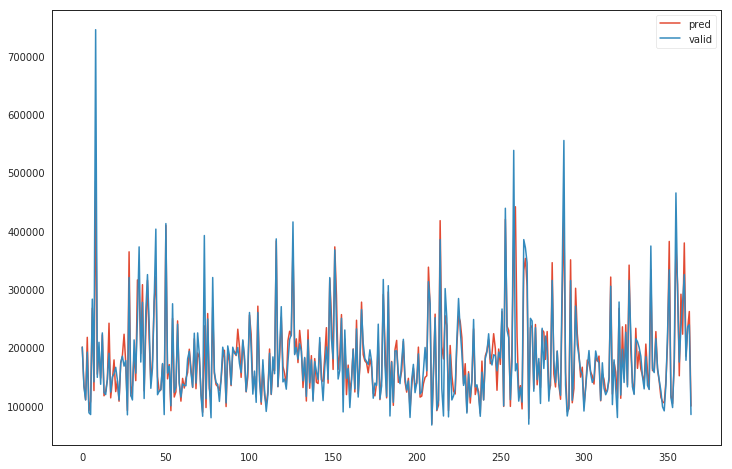

In [160]:
print 'Error Sum:', np.sum(pred_y - valid_y)
sns.lineplot(data=pred_y, label='pred')
sns.lineplot(data=np.array(valid_y.to_list()), label='valid')

# 9. Pipeline优雅的并行处理整个流程

- FeatureUnion - 整体并行；
- 自定义类集成FeatureUnion - 部分[列]并行；
- Pipeline - 流程化；

# 10. 持久化

# 11. 结果输出

使用上一步的Pipeline的结果构建输出文件，上传Kaggle，记录分数；

- V-1.0:0.14775, Top 63%;

In [161]:
rfr = ensemble.RandomForestRegressor(n_estimators=100).fit(train_data, train_target)
result = rfr.predict(test_data)

In [162]:
pd.DataFrame({'Id':list(test_id), 'SalePrice':list(result)}).to_csv('output/submission-0914.csv', index=False)

# 12. 总结

- 模型是使用离散特征还是连续特征，其实是一个“海量离散特征+简单模型” 同 “少量连续特征+复杂模型”的权衡，这也是通常很少直接输入连续特征的原因，因为对模型要求太高，比如要求模型具备自动复杂特征组合的能力，而离散化后的N个特征可以自由组合、单独权重，相当于加入了非线性的特点；
- 组合和持久化都会涉及pickle技术，在sklearn的技术文档中有说明，将lambda定义的函数作为FunctionTransformer的自定义转换函数将不能pickle化；

参考：[使用sklearn做单机特征工程](https://www.cnblogs.com/jasonfreak/p/5448385.html)，[泰坦尼克高级特征工程](https://www.kaggle.com/gunesevitan/advanced-feature-engineering-tutorial-with-titanic?scriptVersionId=13560724)，[连续特征离散化](https://blog.csdn.net/u010358304/article/details/80693541)，[Sklearn官方文档](https://scikit-learn.org/stable/index.html)

===================================================分割线========================================================

## 3.4 Double Check Cleaned Data

In [ ]:
print'All data columns with null values: \n'+str(all_data.isnull().sum())
print("-"*100)
print all_data.info()
print("-"*100)

# Step 4:Visualization and FE

In [ ]:
train_data, test_data = divide_df(all_data)
print len(train_data)
print len(test_data)

## 4.1 Visualization


![可视化流程](./Visualization.png)
需要考虑下面4个问题进行可视化：
1. 我有什么数据？
    - 房屋销售相关数据：训练集1460条、测试集1459条；
    - 房屋相关特征：销售相关、材料相关、地下室、车库、泳池、家私家电等，训练集多一个售价字段；
    - 从维度上讲是很全面的，数量虽然不多，但是也足够项目本身使用；
2. 关于数据你想了解什么？
    - 那些数据对于预测房价起到关键作用；
    - 字段之间的关系，是否需要组合拆分；
    - 连续字段是否要离散化处理；
    - 离散型字段是否要聚合分析；
    - 是否有字段要被舍弃；
3. 应该使用哪种可视化方式？
    - 与目标变量的相关性分析：计算相关系数即可，连续型计算Pearson、离散有序也可以通过Pearson、离散无序可以通过信息增益比；
        - 计算相关系数即可，不需要可视化；
    - 字段之间关系：相关性，相关性高的进行多变量组合可视化，组合变量计算其与目标变量的相关系数，树类的模型的分裂过程其实本质上也相当于在组合变量，只不过都是二维的组合，无法拓展到更高维度，因为这一点，因此特征的组合不需要过度；
        - 计算相关系数即可，不需要可视化；
    - 连续特征可视化其与目标变量的关系，是否cut处理后差异更明显，另外部分树模型需要特征均为离散，因此这里也要考虑这一点；
        - 柱形图可视化其分布情况；
        - 散点图可视化其与目标特征的关系，观察趋势分布等；
    - 离散特征同样可视化其与目标变量的关系，看是否需要聚合；
        - 柱形图可视化其分布情况；
        - 柱形图可视化其与目标特征的关系，对比各个值的情况，是否有足够大的差异可以用于区分目标；
    - 这里后面会考虑先使用随机森林跑结果，因此丢弃特征可以只考虑被挖掘后的特征（比如qcut后的连续特征），以及分布非常倾斜的或者跟目标特征没有一点相关性的（这里要谨慎）；
        - 柱形图可视化分布情况；
4. 看到了什么，有什么意义？
    - 连续特征分布可视化：多数特征分布倾斜严重，部分面积分布符合正态分布；
    - 离散特征分布可视化：多数特征分布倾斜严重，其余偏斜居多；

### 4.1.1 连续特征分布可视化分析

连续特征可视化中，重点在于观察数据的分布形态，是否正态，是否左偏右偏等，可以看到有1stFlrSF这种接近正态分布的，有2ndFlrSF这种有一个极致，剩余的数据符合正态分布的，有3SsnProch这种几乎只有一个取值极度偏斜的，有BsmtUnfSF这种典型左偏的，几个分布很极端的可以考虑后续特征工程时不保留，直接丢弃；

In [ ]:
print ContinuousFeatures

In [ ]:
train_data[ContinuousFeatures].hist(bins=30, color='steelblue', edgecolor='black', linewidth=1.0,
           xlabelsize=8, ylabelsize=8, grid=False)
plt.tight_layout(rect=(0, 0, 1.2, 1.2))

### 4.1.2 离散特征分布可视化分析

In [ ]:
print CategoricalFeatures

In [ ]:
cate_labels = [cf+'_label' for cf in CategoricalFeatures]
tmp = train_data.copy(deep=True)
for cf in CategoricalFeatures:
    tmp[cf+'_label'] = le.fit_transform(tmp[cf])
tmp[cate_labels].hist(bins=30, color='steelblue', edgecolor='black', linewidth=1.0,
           xlabelsize=8, ylabelsize=8, grid=False)
plt.tight_layout(rect=(0, 0, 1.2, 1.2))

### 4.1.3 与目标变量相关性计算

连续、离散中均取前10个特征进行与目标特征的可视化及分析；

In [ ]:
corr_df(train_data[ContinuousFeatures+['SalePrice']], 'SalePrice', min_=0)[:10]

In [ ]:
gain_df(tmp[cate_labels+['SalePrice']], 'SalePrice')[:10]

### 4.1.4 Top10连续特征与目标特征关系可视化分析

1. GrLivArea：
2. GarageCars：
3. GarageArea：
4. TotalBsmtSF：
5. 1stFlrSF：
6. FullBath：
7. TolRmsAbvGrd：
8. MasVnrArea：
9. Fireplaces：
10. BsmtFinSF1：

#### 4.1.4.1 GrLivArea

地上生活面积，与售价相关性最强的特征，可以理解，毕竟与总面积相比，地上生活面积与院子、泳池、车库等每平米价钱肯定是不同的，散点图中看，整体趋势是正相关的，存在两个异常点在右下方，即面积很大，但是售价不高的case，看到多变量分析中，增加了TotRmsAbvGrd、2ndFlrSF、FullBath后，趋势上更接近正相关；

_ = sns.relplot(x="GrLivArea", y="SalePrice", data=train_data)

_ = sns.relplot(x="GrLivArea", y="SalePrice", data=train_data)

corr_df(train_data.drop('SalePrice', axis=1), 'GrLivArea', min_=0)[:3]

train_data['TotRmsAbvGrd_group'] = train_data.TotRmsAbvGrd.apply(lambda trag:'normal' if trag<=9 else 'more')

_ = sns.relplot(x="GrLivArea", y="SalePrice", col='TotRmsAbvGrd_group', hue='FullBath', size='2ndFlrSF', sizes=(10,100), data=train_data)

### 4.1.5 Top10离散特征与目标特征关系可视化分析

- 'Street_label', (0.030899269705326304, 0.8027340952425503)
- 'YearBuilt_label', (4.693292332369521, 0.7488927774240633)
- 'GarageYrBlt_label', (4.577512176649363, 0.7441663406989903)
- 'SaleType_label', (0.5821581227342438, 0.7439052233794641)
- 'Condition2_label', (0.07970893717408067, 0.7379736808443585)
- 'ExterQual_label', (0.868712417834896, 0.7292286989531186)
- 'Heating_label', (0.13710479607781068, 0.7218057881414142)
- 'YearRemodAdd_label', (3.8307121785081346, 0.7173639095940105)
- 'PoolQC_label', (0.0367771375642878, 0.7168650009445736)
- 'RoofMatl_label', (0.11854637368093002, 0.7055569986712363)

_, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 20))
vc = train_data.MSSubClass.value_counts()
sns.barplot(x=list(vc.index), y=list(vc.values), ax=ax1)
ax1.set_title('MSSubClass Value Count')
sns.barplot(x="MSSubClass", y="SalePrice", data=train_data, ax=ax2)
ax2.set_title('MSSubClass Every Value SalePrice')
sns.barplot(x="MSSubClass", y="SalePrice", hue="MSZoning", data=train_data, ax=ax3)
ax3.set_title('MSSubClass Every Value SalePrice With MSZoning')

## 4.2 Feature Engineering

- 2019-09-08:v1.0
    - 连续特征离散化；
    - 离散特征聚合处理；
    - 特征LabelEncode（部分有序的手动指定数字）；
    - 无序离散特征OneHot处理；

In [ ]:
train_data.info()

In [ ]:
test_data.info()

### 4.2.1 Continuous Features

In [ ]:
print ContinuousFeatures

#### LotArea - 面积

分箱处理，分为5个箱，看到结果是正相关的；

In [ ]:
g = sns.relplot(x="LotArea", y="SalePrice", data=train_data)

In [ ]:
train_data['tmp'] = pd.qcut(train_data['LotArea'], 5)
g = sns.catplot(x="tmp", y="SalePrice", kind='bar', data=train_data)
g.fig.set_figwidth(18)

#### LotFrontage - 距离街道的直线距离

分箱处理，分为10个箱，看到结果各个箱之间差异不是很明显，因为可以理解为短的距离比较方便，远的距离比较安静，但是距离远一般说明带院子，所以接近正相关；

In [ ]:
g = sns.relplot(x="LotFrontage", y="SalePrice", data=train_data)

In [ ]:
train_data['tmp'] = pd.qcut(train_data['LotFrontage'], 10, duplicates='drop')
g = sns.catplot(x="tmp", y="SalePrice", kind='bar', data=train_data)
g.fig.set_figwidth(18)

#### MasVnrArea - 地砖面积

分箱处理，分10个，注意去重后只剩5个；

In [ ]:
g = sns.relplot(x="MasVnrArea", y="SalePrice", data=train_data)

In [ ]:
train_data['tmp'] = pd.qcut(train_data['MasVnrArea'], 10, duplicates='drop')
g = sns.catplot(x="tmp", y="SalePrice", kind='bar', data=train_data)
g.fig.set_figwidth(18)

#### BsmtFinSF1 - 地下室完成面积1

分10个箱，看到806是分界线，手动按照800划分，这里使用按照800划分的方式，差异更明显；

In [ ]:
g = sns.relplot(x="BsmtFinSF1", y="SalePrice", data=train_data)

In [ ]:
train_data['tmp'] = pd.qcut(train_data['BsmtFinSF1'], 10, duplicates='drop')
g = sns.catplot(x="tmp", y="SalePrice", kind='bar', data=train_data)
g.fig.set_figwidth(18)

In [ ]:
train_data['tmp'] = train_data.BsmtFinSF1.apply(lambda sf1:'small' if sf1<=800 else 'big')
g = sns.catplot(x="tmp", y="SalePrice", kind='bar', data=train_data)
g.fig.set_figwidth(18)

#### BsmtFinSF2 - 地下室完成面积2

很多数据中看该特征均为0，且为0的情况下，依然存在各个价位，因此该特征不具备太多解释性，分箱中看到基本没有差异，因此直接该特征被丢弃；

In [ ]:
g = sns.relplot(x="BsmtFinSF2", y="SalePrice", data=train_data)

In [ ]:
train_data['tmp'] = pd.qcut(train_data['BsmtFinSF2'], 10, duplicates='drop')
g = sns.catplot(x="tmp", y="SalePrice", kind='bar', data=train_data)
g.fig.set_figwidth(18)

#### BsmtUnfSF - 地下室未完成面积

关系图上看，基本没有明显趋势，分箱上看不具备一致的相关性，挖掘其是否地下室完成字段，可以看到还是有明显差异的，未完工的地下室对应售价更高，因此使用该字段；

In [ ]:
g = sns.relplot(x="BsmtUnfSF", y="SalePrice", data=train_data)

In [ ]:
train_data['tmp'] = pd.qcut(train_data['BsmtUnfSF'], 10, duplicates='drop')
g = sns.catplot(x="tmp", y="SalePrice", kind='bar', data=train_data)
g.fig.set_figwidth(18)

In [ ]:
train_data['tmp'] = train_data.BsmtUnfSF.apply(lambda unf:'finish' if unf<=0 else 'unfinish')
g = sns.catplot(x="tmp", y="SalePrice", kind='bar', data=train_data)
g.fig.set_figwidth(18)

#### TotalBsmtSF - 地下室总面积

关系图上看有明显正相关，箱行图上看正相关的趋势更加明显，分箱5，看到一致的正相关趋势；

In [ ]:
g = sns.relplot(x="TotalBsmtSF", y="SalePrice", data=train_data)

In [ ]:
train_data['tmp'] = pd.qcut(train_data['TotalBsmtSF'], 5, duplicates='drop')
g = sns.catplot(x="tmp", y="SalePrice", kind='bar', data=train_data)
g.fig.set_figwidth(18)

#### 1stFlrSF - 1楼面积

关系图上看非常明显的正相关，带有个别异常值，箱行图上看分箱5个，趋势明显，做分箱处理；

In [ ]:
g = sns.relplot(x="1stFlrSF", y="SalePrice", data=train_data)

In [ ]:
train_data['tmp'] = pd.qcut(train_data['1stFlrSF'], 5, duplicates='drop')
g = sns.catplot(x="tmp", y="SalePrice", kind='bar', data=train_data)
g.fig.set_figwidth(18)

#### 2ndFlrSF - 二楼面积

关系图上看相当一部分没有二楼，其余数据有一定正相关性，箱行图上看去掉没有二楼的数据后，数据呈现正相关趋势，手动进行分段处理后差异明显；

In [ ]:
g = sns.relplot(x="2ndFlrSF", y="SalePrice", data=train_data)

In [ ]:
train_data['tmp'] = pd.qcut(train_data['2ndFlrSF'], 15, duplicates='drop')
g = sns.catplot(x="tmp", y="SalePrice", kind='bar', data=train_data)
g.fig.set_figwidth(18)

In [ ]:
train_data['tmp'] = pd.qcut(train_data['2ndFlrSF'], 15, duplicates='drop')
g = sns.catplot(x="tmp", y="SalePrice", kind='bar', data=train_data[train_data['2ndFlrSF']>0])
g.fig.set_figwidth(18)

In [ ]:
train_data['tmp'] = train_data['2ndFlrSF'].apply(lambda flrsf2:0 if flrsf2<=0 else (1 if flrsf2<=500 else (2 if flrsf2<=800 else (3 if flrsf2<=1000 else 4))))
g = sns.catplot(x="tmp", y="SalePrice", kind='bar', data=train_data)
g.fig.set_figwidth(18)

#### LowQualFinSF - 低质量部分面积

绝大部分都为0，少部分不为0的也没有相关关系存在，看是否为0有一定差异，该特征二值化处理；

In [ ]:
g = sns.relplot(x="LowQualFinSF", y="SalePrice", data=train_data)

In [ ]:
train_data['tmp'] = train_data.LowQualFinSF.apply(lambda lowsf:0 if lowsf<=0 else 1)
g = sns.catplot(x="tmp", y="SalePrice", kind='bar', data=train_data)
g.fig.set_figwidth(18)

#### GrLivArea - 地上生活区面积

关系图上看，与售价的正相关很强，分箱后明显的上升趋势，分10个箱处理；

In [ ]:
g = sns.relplot(x="GrLivArea", y="SalePrice", data=train_data)

In [ ]:
train_data['tmp'] = pd.qcut(train_data['GrLivArea'], 10, duplicates='drop')
g = sns.catplot(x="tmp", y="SalePrice", kind='bar', data=train_data)
g.fig.set_figwidth(18)

#### BsmtFullBath - 地下室全浴室个数

虽然也是连续特征，但是指的是个数，个数之间是否存在倍数关系不好说，因此这个特征其实作为离散特征分析也是可以的，相关图上看不出趋势规则，柱形图上看有差异，不明显，构建是否有地下室全浴室字段看，差异在30000左右；

In [ ]:
g = sns.relplot(x="BsmtFullBath", y="SalePrice", data=train_data)

In [ ]:
#train_data['tmp'] = pd.qcut(train_data['1stFlrSF'], 5, duplicates='drop')
g = sns.catplot(x="BsmtFullBath", y="SalePrice", kind='bar', data=train_data)
g.fig.set_figwidth(18)

In [ ]:
train_data['tmp'] = train_data.BsmtFullBath.apply(lambda fb:0 if fb<=0 else 1)
g = sns.catplot(x="tmp", y="SalePrice", kind='bar', data=train_data)
g.fig.set_figwidth(18)

#### BsmtHalfBath - 地下室半浴室个数

相关图上看不出明显关系，且存在离群点，柱形图上看也是基本没差异，因此丢弃该特征；

In [ ]:
g = sns.relplot(x="BsmtHalfBath", y="SalePrice", data=train_data)

In [ ]:
#train_data['tmp'] = pd.qcut(train_data['1stFlrSF'], 5, duplicates='drop')
g = sns.catplot(x="BsmtHalfBath", y="SalePrice", kind='bar', data=train_data)
g.fig.set_figwidth(18)

#### FullBath - 全浴室个数，不包括地下

相关图上看具有一定的正相关关系，直接看柱形图发现0大于1,2大于1，3大于2，聚合0,1得到有一个或者没有全浴室，2,3有多个全浴室，看到差异明显，再看跟地下室全浴室相加后的柱形图趋势有反复，没有明确的正负相关关系，采用是否多个全浴室字段；

In [ ]:
g = sns.relplot(x="FullBath", y="SalePrice", data=train_data)

In [ ]:
g = sns.catplot(x="FullBath", y="SalePrice", kind='bar', data=train_data)
g.fig.set_figwidth(18)

In [ ]:
train_data['tmp'] = train_data.FullBath.apply(lambda fb:'one' if fb<=1 else 'more')
g = sns.catplot(x="tmp", y="SalePrice", kind='bar', data=train_data)
g.fig.set_figwidth(18)

In [ ]:
train_data['tmp'] = train_data.FullBath+train_data.BsmtFullBath
g = sns.catplot(x="tmp", y="SalePrice", kind='bar', data=train_data)
g.fig.set_figwidth(18)

#### HalfBath - 半浴室，不包括地下

相关图上看，每个数值对应的售价分布都很广泛且相互覆盖，不具备足够的差异以划分数据集，构建是否有一个半浴室字段，差异较明显，保留；

In [ ]:
g = sns.relplot(x="HalfBath", y="SalePrice", data=train_data)

In [ ]:
g = sns.catplot(x="HalfBath", y="SalePrice", kind='bar', data=train_data)
g.fig.set_figwidth(18)

In [ ]:
train_data['tmp'] = train_data.HalfBath.apply(lambda fb:0 if fb==1 else 1)
g = sns.catplot(x="tmp", y="SalePrice", kind='bar', data=train_data)
g.fig.set_figwidth(18)

#### BedroomAbvGr - 地上卧室个数

售价并没有随着卧室个数的增加而持续增加，相反在大于等于5个卧室的情况下，反而售价都在350000以下；

In [ ]:
g = sns.relplot(x="BedroomAbvGr", y="SalePrice", data=train_data)

In [ ]:
g = sns.catplot(x="BedroomAbvGr", y="SalePrice", kind='bar', data=train_data)
g.fig.set_figwidth(18)

#### KitchenAbvGr - 地上厨房个数

构建有且仅有一个厨房特征；

In [ ]:
g = sns.relplot(x="KitchenAbvGr", y="SalePrice", data=train_data)

In [ ]:
g = sns.catplot(x="KitchenAbvGr", y="SalePrice", kind='bar', data=train_data)
g.fig.set_figwidth(18)

In [ ]:
train_data['tmp'] = train_data.KitchenAbvGr.apply(lambda fb:0 if fb==1 else 1)
g = sns.catplot(x="tmp", y="SalePrice", kind='bar', data=train_data)
g.fig.set_figwidth(18)

#### TotRmsAbvGrd - 地上房间个数，不包括卧室

相关图上看有一定的正相关关系，柱形图上看峰值在11，之后12和13都有下降（可能跟格局有关，过于多的房间个数，在格局上不受欢迎）；

In [ ]:
g = sns.relplot(x="TotRmsAbvGrd", y="SalePrice", data=train_data)

In [ ]:
g = sns.catplot(x="TotRmsAbvGrd", y="SalePrice", kind='bar', data=train_data)
g.fig.set_figwidth(18)

#### Fireplaces - 壁炉个数

相关图上看，没有壁炉的情况售价在350000内，有壁炉的售价分布就比较广泛，或者说售价高的房子都是有壁炉的，可能是1个2个3个，但是肯定都有，因此构建一个是否有壁炉的特征；

In [ ]:
g = sns.relplot(x="Fireplaces", y="SalePrice", data=train_data)

In [ ]:
train_data['tmp'] = train_data.Fireplaces.apply(lambda fps:0 if fps<=0 else 1)
g = sns.catplot(x="tmp", y="SalePrice", kind='bar', data=train_data)
g.fig.set_figwidth(18)

#### GarageCars - 车库可以停放多少辆车

看到明显的正相关，这里主要跟车库面积有关，而面积基本都是正相关的，比较特别的是值为4的情况下，售价反而不高

In [ ]:
g = sns.relplot(x="GarageCars", y="SalePrice", data=train_data)

In [ ]:
g = sns.catplot(x="GarageCars", y="SalePrice", kind='bar', data=train_data)
g.fig.set_figwidth(18)

#### GarageArea - 车库面积

明显正相关，存在离群异常点，qcut处理来弥补，柱形图上看分箱5处理，头尾差异明显；

In [ ]:
g = sns.relplot(x="GarageArea", y="SalePrice", data=train_data)

In [ ]:
train_data['tmp'] = pd.qcut(train_data.GarageArea, 5, duplicates='drop')
g = sns.catplot(x="tmp", y="SalePrice", kind='bar', data=train_data)
g.fig.set_figwidth(18)

#### WoodDeckSF - 木地板面积

相关图上看，相当一部分数据没有木地板，其他数据有一定的正相关，分箱后的柱形图上依然看不出，构建一个是否有木地板特征看到存在一定的差异；

In [ ]:
g = sns.relplot(x="WoodDeckSF", y="SalePrice", data=train_data)

In [ ]:
train_data['tmp'] = pd.qcut(train_data.WoodDeckSF, 10, duplicates='drop')
g = sns.catplot(x="tmp", y="SalePrice", kind='bar', data=train_data)
g.fig.set_figwidth(18)

In [ ]:
train_data['tmp'] = train_data.WoodDeckSF.apply(lambda wdsf:0 if wdsf <=0 else 1)
g = sns.catplot(x="tmp", y="SalePrice", kind='bar', data=train_data)
g.fig.set_figwidth(18)

#### OpenPorchSF - 开放式门廊面积

情况跟木地板面积类型，构建是否有开放式门廊特征；

In [ ]:
g = sns.relplot(x="OpenPorchSF", y="SalePrice", data=train_data)

In [ ]:
train_data['tmp'] = train_data.OpenPorchSF.apply(lambda opsf:0 if opsf<=0 else 1)
g = sns.catplot(x="tmp", y="SalePrice", kind='bar', data=train_data)
g.fig.set_figwidth(18)

#### EnclosedPorch - 围挡走廊面积

情况跟木地板面积类型，构建是否有围挡门廊特征；

In [ ]:
g = sns.relplot(x="EnclosedPorch", y="SalePrice", data=train_data)

In [ ]:
train_data['tmp'] = train_data.EnclosedPorch.apply(lambda opsf:0 if opsf<=0 else 1)
g = sns.catplot(x="tmp", y="SalePrice", kind='bar', data=train_data)
g.fig.set_figwidth(18)

#### 3SsnPorch - 三季围廊面积

情况跟木地板面积类型，构建是否有三季门廊特征；

In [ ]:
g = sns.relplot(x="3SsnPorch", y="SalePrice", data=train_data)

In [ ]:
train_data['tmp'] = train_data['3SsnPorch'].apply(lambda opsf:0 if opsf<=0 else 1)
g = sns.catplot(x="tmp", y="SalePrice", kind='bar', data=train_data)
g.fig.set_figwidth(18)

#### ScreenPorch - 屏风廊面积

情况跟木地板面积类型，构建是否有屏风门廊特征；

In [ ]:
g = sns.relplot(x="ScreenPorch", y="SalePrice", data=train_data)

In [ ]:
train_data['tmp'] = train_data.ScreenPorch.apply(lambda opsf:0 if opsf<=0 else 1)
g = sns.catplot(x="tmp", y="SalePrice", kind='bar', data=train_data)
g.fig.set_figwidth(18)

#### PoolArea - 泳池面积

基本所有数据都没有泳池，极少数有，也不存在相关性，构建是否有泳池特征；

In [ ]:
g = sns.relplot(x="PoolArea", y="SalePrice", data=train_data)

In [ ]:
train_data['tmp'] = train_data.PoolArea.apply(lambda opsf:0 if opsf<=0 else 1)
g = sns.catplot(x="tmp", y="SalePrice", kind='bar', data=train_data)
g.fig.set_figwidth(18)

#### MiscVal - 杂项价值

很直接的特征，可惜大部分数据杂项都为0，构建是否有杂项特征，可以看到该特征差异依然不大，考虑是否需要保留；

In [ ]:
g = sns.relplot(x="MiscVal", y="SalePrice", data=train_data)

In [ ]:
train_data['tmp'] = train_data.MiscVal.apply(lambda mv:0 if mv<=0 else 1)
g = sns.catplot(x="tmp", y="SalePrice", kind='bar', data=train_data)
g.fig.set_figwidth(18)

### 4.2.2 Categorical Features

In [ ]:
print CategoricalFeatures

#### MSSubClass - 房屋类型（风格）

- 20	1-STORY 1946 & NEWER ALL STYLES
- 30	1-STORY 1945 & OLDER
- 40	1-STORY W/FINISHED ATTIC ALL AGES
- 45	1-1/2 STORY - UNFINISHED ALL AGES
- 50	1-1/2 STORY FINISHED ALL AGES
- 60	2-STORY 1946 & NEWER
- 70	2-STORY 1945 & OLDER
- 75	2-1/2 STORY ALL AGES
- 80	SPLIT OR MULTI-LEVEL
- 85	SPLIT FOYER
- 90	DUPLEX - ALL STYLES AND AGES
- 120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
- 150	1-1/2 STORY PUD - ALL AGES
- 160	2-STORY PUD - 1946 & NEWER
- 180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
- 190	2 FAMILY CONVERSION - ALL STYLES AND AGES

按照前缀划分：
- 1-STORY:20,30,40,120,
- 1-1/2 STORY:45,50,150,
- 2-STORY:60,70,160,
- 2-1/2 STORY:75,
- SPLIT:80,85,
- DUPLEX:90,
- PUD:180,
- 2 FAMILY:190,

柱形图上看，各个风格对应售价差异明显，按前缀划分后差异没有更加明显，因此不做该处理，该特征保持原样；

In [ ]:
g = sns.catplot(x="MSSubClass", y="SalePrice", data=train_data, saturation=.5, kind="bar", aspect=.6)
g.fig.set_figwidth(18)

style1 = [20,30,40,120]
style2 = [45,50,150]
style3 = [60,70,160]
style4 = [75]
style5 = [85]
style6 = [90]
style7 = [180]
style8 = [190]
train_data['tmp'] = train_data.MSSubClass.apply(lambda msc:1 if msc in style1 else (2 if msc in style2 else(3 if msc in style3 else(4 if msc in style4 else(5 if msc in style5 else(6 if msc in style6 else(7 if msc in style7 else(8 if msc in style8 else 9))))))))
g = sns.catplot(x="tmp", y="SalePrice", data=train_data, saturation=.5, kind="bar", aspect=.6)
g.fig.set_figwidth(18)

#### LotShape - 房屋户型形状，LotConfig - 所处街角位置

单独看两个特征差异都不明显，组合看到差异是较为明显的；

In [ ]:
g = sns.catplot(x="LotShape", y="SalePrice", data=train_data, saturation=.5, kind="bar", aspect=.6)
g.fig.set_figwidth(18)

In [ ]:
g = sns.catplot(x="LotConfig", y="SalePrice", data=train_data, saturation=.5, kind="bar", aspect=.6)
g.fig.set_figwidth(18)

In [ ]:
train_data['tmp'] = train_data.LotShape + train_data.LotConfig
g = sns.catplot(x="tmp", y="SalePrice", data=train_data, saturation=.5, kind="bar", aspect=.6)
g.fig.set_figwidth(18)

#### Street - 街道是Grvl砾石还是铺砌Pave

因为只有两个取值，因此直接二值化即可；

In [ ]:
g = sns.catplot(x="Street", y="SalePrice", data=train_data, saturation=.5, kind="bar", aspect=.6)
g.fig.set_figwidth(18)

#### Alley - 通向房屋的小巷子类型：Grvl砾石还是铺砌Pave或者没有

差异明显，则不进行处理，后续OneHot即可；

In [ ]:
g = sns.catplot(x="Alley", y="SalePrice", data=train_data, saturation=.5, kind="bar", aspect=.6)
g.fig.set_figwidth(18)

#### LandContour - 地面平整程度，LandSlope - 地面坡度

组合分析看到，不同的地面平整类型下对应不同坡度与售价的关系是不同的，例如Bnk下坡度对售价基本无影响，而Low下是上升，HLS是下降，Lvl是中间突出，组合两个特征关系图看到差异明显，因此使用组合两个特征；

In [ ]:
g = sns.catplot(x="LandSlope", y="SalePrice", col='LandContour', data=train_data, saturation=.5, kind="bar", aspect=.6)
g.fig.set_figwidth(18)

In [ ]:
train_data['tmp'] = train_data.LandContour + train_data.LandSlope
g = sns.catplot(x="tmp", y="SalePrice", data=train_data, saturation=.5, kind="bar", aspect=.6)
g.fig.set_figwidth(18)

#### Utilities - 可用公共设施，应该是随着可用的增加正相关的

这里只看训练数据看到是正相关的，因此考虑测试数据应该也符合这个特点，因此不处理该特征，作为有序离散映射后不做OneHot；

In [ ]:
g = sns.catplot(x="Utilities", y="SalePrice", data=train_data, saturation=.5, kind="bar", aspect=.6)
g.fig.set_figwidth(18)

#### Neighborhood - 社区

埃姆斯市，是爱荷华州的第八大城市，在爱荷华州州府得梅因北部约30公里处，2018年预计居住有67154人，是爱荷华州立大学和美国能源部埃姆斯实验室坐落的地方。埃姆斯市无论在生活和工作环境上都在美国小型城市中名列前茅，拥有全美治安良好城市的美称。这里居民和善，安居乐业，平均个人所得高，社会安全问题不多，整座城市艺术气息浓厚、活力充沛。距离堪萨斯城，奥马哈及芝加哥有半天路程。埃姆斯以小镇氛围并且接近大多数娱乐设施而闻名, 所有设施和费用，价廉物美；

比较重要，且存在挖掘的可能，需要对实际情况有所了解，当前先从基本手段下分析该特征，

In [ ]:
g = sns.catplot(x="Neighborhood", y="SalePrice", data=train_data, saturation=.5, kind="bar", aspect=.6)
g.fig.set_figwidth(22)

#### 'MSZoning', 'LotShape', 'Street', 'Alley', 'LandContour', 'LandSlope', 'Utilities', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition'

### 4.2.3 Label Encode

### 4.2.4 One-Hot Encode

# Step 5:Model Data

## 5.0 Split Data to Train and Test

In [ ]:
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(train_data, train_target, random_state = 0)

## 5.1 Evaluate Model Performance

In [ ]:
#Machine Learning Algorithm (MLA) Selection and Initialization
MLA = [
    #Ensemble Methods
    ensemble.AdaBoostRegressor(),
    ensemble.BaggingRegressor(),
    ensemble.ExtraTreesRegressor(),
    ensemble.GradientBoostingRegressor(),
    ensemble.RandomForestRegressor(),
    
    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
    XGBRegressor(),
]



#split dataset in cross-validation with this splitter class: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html#sklearn.model_selection.ShuffleSplit
#note: this is an alternative to train_test_split
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .1, train_size = .8, random_state = 0 ) # run model 10x with 60/30 split intentionally leaving out 10%

#create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD' ,'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

#index through MLA and save performance to table
row_index = 0
for alg in MLA:
    #set name and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    
    #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    cv_results = model_selection.cross_validate(alg, train_data, train_target, cv  = cv_split)

    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()   
    #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3   #let's know the worst that can happen!
    
    row_index+=1
    
#print and sort table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare

def ensemble_predict(mla, train_x, train_y, test_x):
    len_ = len(mla)
    res = [0]*len(test_x)
    for ml in mla:
        ml.fit(train_x, train_y)
        test_y = ml.predict(test_x)
        res = [res[j]+1.*test_y[j]/len_ for j in range(len(test_y))]
    return res

ensemble_res = ensemble_predict(MLA, train_data, train_target, test_data)

In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")

In [ ]:
for alg in MLA:
    plot_learning_curve(alg, alg.__class__.__name__, train_data, train_target, cv=cv_split)

# Step 8: Submit

In [ ]:
pd.DataFrame({'Id':list(test_id), 'SalePrice':list(ensemble_res)}).to_csv('output/submission.csv', index=False)